# Bag of Words Sentiment Analyse von McDonalds Reviews und IMBD Daten

## Zielsetzung 
In diesem Notebook erweitern wir die McDonald's-Daten mit IMDB-Daten, um die Auswirkungen auf die Genauigkeit zu erforschen. Dafür teilen wir die Daten in positive und negative Reviews auf, was zu nur zwei Labels führt. Die Baseline basierend auf dem gesunden Menschenverstand liegt daher bei einer Genauigkeit von 50%.
 Unser Ziel ist es herauszufinden, ob wir durch Hinzufügen immer mehr Daten eine allgemeine Semantikanalyse erreichen können, die auf jede beliebige Review angewendet werden kann.

In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow import keras
from tensorflow.keras import layers


## Datenvorbereitung inkl. Behandlung bekannter Probleme

### Laden der Daten

In [24]:
%pip install kaggle


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [25]:
import os

# Download McDonalds dataset
if not os.path.exists('mcdonalds-store-reviews.zip'):
    print("Downloading McDonalds dataset...")
    !kaggle datasets download -d nelgiriyewithana/mcdonalds-store-reviews
if os.path.exists('mcdonalds-store-reviews.zip'):
    print("Unzipping McDonalds dataset...")
    !unzip -n mcdonalds-store-reviews.zip

# Download IMDB dataset
if not os.path.exists('imdb-dataset-of-50k-movie-reviews.zip'):
    print("Downloading IMDB dataset...")
    !kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
if os.path.exists('imdb-dataset-of-50k-movie-reviews.zip'):
    print("Unzipping IMDB dataset...")
    !unzip -n imdb-dataset-of-50k-movie-reviews.zip

Unzipping McDonalds dataset...
Archive:  mcdonalds-store-reviews.zip
Unzipping IMDB dataset...
Archive:  imdb-dataset-of-50k-movie-reviews.zip


In [26]:
df_mc = pd.read_csv('McDonald_s_Reviews.csv', encoding="latin-1")
df_imdb = pd.read_csv('IMDB Dataset.csv')

In [27]:
df_mc.head()

,reviewer_id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating
0,1,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 months ago,Why does it look like someone spit on my food?...,1 star
1,2,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,It'd McDonalds. It is what it is as far as the...,4 stars
2,3,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,Made a mobile order got to the speaker and che...,1 star
3,4,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",a month ago,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5 stars
4,5,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",2 months ago,"I repeat my order 3 times in the drive thru, a...",1 star


In [28]:
df_imdb.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### Bereinigung der Daten

In [29]:
from utils.text_utils import clean_text

df_mc['review'] = df_mc['review'].apply(clean_text)
df_imdb['review'] = df_imdb['review'].apply(clean_text)
df_mc = df_mc[['review', 'rating']]
df_imdb = df_imdb[['review', 'sentiment']]

In [30]:
df_mc.head()

,review,rating
0,why does it look like someone spit on my food\...,1 star
1,it would mcdonalds it is what it is as far as ...,4 stars
2,made a mobile order got to the speaker and che...,1 star
3,my mc crispy chicken sandwich was customer se...,5 stars
4,i repeat my order 3 times in the drive thru an...,1 star


In [31]:
df_imdb.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production the filming tech...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there is a family where a little boy...,negative
4,petter matteis love in the time of money is a ...,positive


### Löschen der 3 Sterne Bewertungen beim McDonalds Dataset

In [32]:
df_mc = df_mc[df_mc['rating'] != '3 stars']

In [33]:
print(df_mc.columns)
print(df_imdb.columns)

Index(['review', 'rating'], dtype='object')
Index(['review', 'sentiment'], dtype='object')


### Konvertierung der train data zu numpy arrays

In [34]:
data_mc = df_mc['review'].to_numpy()
data_imdb = df_imdb['review'].to_numpy()


### Konvertierung der Datasets von string labels zu Nummern

In [35]:
rating_mapping_imdb = {
    'positive': 1,
    'negative': 0,
}

label_imdb = df_imdb['sentiment'].map(rating_mapping_imdb).to_numpy()


In [36]:
rating_mapping_mc = {
    '1 star': 0,
    '2 stars': 0,
    '4 stars': 1,
    '5 stars': 1
}

label_mc = df_mc['rating'].map(rating_mapping_mc).to_numpy()

### Daten zusammenführen

In [37]:
data = np.append(data_imdb, data_mc)
label = np.append(label_imdb,label_mc)
print(data.shape)
print(label.shape)

(78578,)
(78578,)


### Aufteilung in Trainings, Validierungs und Testdaten

In [38]:
train_data, test_data, train_label, test_label = train_test_split(data, label, test_size=0.2, random_state=42)

print(train_data.shape)
print(test_data.shape)
print(train_label.shape)
print(test_label.shape)

(62862,)
(15716,)
(62862,)
(15716,)


#### McDonalds Train/Test split

Um die Veränderung des Ergbnisses, durch das Einführen von Testsdaten vergleichen zu können, werden wir später auch noch ein Model nur mit den McD Daten trainieren

In [39]:
train_data_mc, test_data_mc, train_label_mc, test_label_mc = train_test_split(data_mc, label_mc, test_size=0.2, random_state=42)

print(train_data_mc.shape)
print(test_data_mc.shape)
print(train_label_mc.shape)
print(test_label_mc.shape)

(22862,)
(5716,)
(22862,)
(5716,)


#### IMDB Train/Test split

Um die Veränderung des Ergbnisses, durch das Einführen von Testsdaten vergleichen zu können, werden wir später auch noch ein Model nur mit den McD Daten trainieren

In [40]:
train_data_imdb, test_data_imdb, train_label_imdb, test_label_imdb = train_test_split(data_imdb, label_imdb, test_size=0.2, random_state=42)

print(train_data_imdb.shape)
print(test_data_imdb.shape)
print(train_label_imdb.shape)
print(test_label_imdb.shape)

(40000,)
(10000,)
(40000,)
(10000,)


### Text zu Dictonary Repräsentationen umbauen
Erklärung Menge an Tokens
Erklärung ngrams 
Erklärung multi_hot und warum

In [41]:
text_vectorization = TextVectorization(
 max_tokens=20000,
ngrams=2,
 output_mode="multi_hot",
 standardize=None,
)

In [42]:
text_vectorization.adapt(train_data) 
text_vectorization.adapt(test_data) 

multi_hot_train_data = text_vectorization(train_data)
multi_hot_test_data = text_vectorization(test_data)

#### Text Vectorization für McD

In [43]:
multi_hot_train_data_mc = text_vectorization(train_data_mc)
multi_hot_test_data_mc = text_vectorization(test_data_mc)

#### Text Vectorization für IMDB

In [44]:
multi_hot_train_data_imdb = text_vectorization(train_data_imdb)
multi_hot_test_data_imdb = text_vectorization(test_data_imdb)

## Erstellung eines entsprechenden künstlichen neuronalen Models sowie geeigente Benchmarks

In [45]:
def get_model(max_tokens=20000, hidden_dim=32):
 inputs = keras.Input(shape=(max_tokens,))
 x = layers.Dense(hidden_dim, activation="relu")(inputs)
 x = layers.Dropout(0.5)(x)
 outputs = layers.Dense(1, activation="sigmoid")(x)
 model = keras.Model(inputs, outputs)
 model.compile(optimizer="rmsprop",
 loss="binary_crossentropy",
 metrics=["accuracy"], 
 )
 return model

model = get_model()
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense (Dense)               (None, 32)                640032    
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 640,065
Trainable params: 640,065
Non-trainable params: 0
_________________________________________________________________


In [46]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",  # Metric to monitor
        patience=3,  # Number of epochs with no improvement after which training will be stopped
        restore_best_weights=True,  # Restore the weights of the best epoch
    )
]

In [47]:
history = model.fit(multi_hot_train_data,train_label,
validation_split=0.2,
 epochs=10, 
 callbacks= callbacks
 )

Epoch 1/10


1572/1572 [==============================] - 14s 9ms/step - loss: 0.3483 - accuracy: 0.8690 - val_loss: 0.2964 - val_accuracy: 0.8972
Epoch 2/10
1572/1572 [==============================] - 14s 9ms/step - loss: 0.2658 - accuracy: 0.9061 - val_loss: 0.3083 - val_accuracy: 0.9011
Epoch 3/10
1572/1572 [==============================] - 14s 9ms/step - loss: 0.2473 - accuracy: 0.9190 - val_loss: 0.3168 - val_accuracy: 0.8999
Epoch 4/10
1572/1572 [==============================] - 15s 10ms/step - loss: 0.2382 - accuracy: 0.9236 - val_loss: 0.3303 - val_accuracy: 0.8998


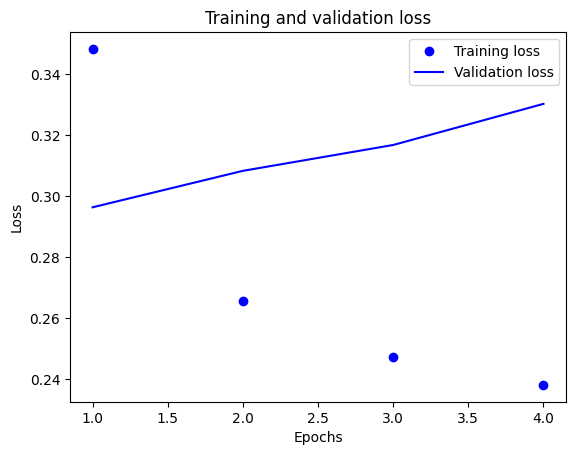

In [48]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Evaluierung auf alle Daten


In [49]:
model.evaluate(multi_hot_test_data, test_label)

492/492 [==============================] - 1s 2ms/step - loss: 0.2789 - accuracy: 0.9028


[0.2789086103439331, 0.9027742147445679]

### Evalurierung nur auf die McDonalds Daten

In [50]:
model.evaluate(multi_hot_test_data_mc, test_label_mc)

179/179 [==============================] - 0s 3ms/step - loss: 0.2468 - accuracy: 0.9055


[0.246779665350914, 0.9055283665657043]

### Evalurierung nur auf die IMDB Daten

In [51]:
model.evaluate(multi_hot_test_data_imdb, test_label_imdb)

313/313 [==============================] - 1s 2ms/step - loss: 0.2291 - accuracy: 0.9195


[0.22908900678157806, 0.9194999933242798]

## Vergleich nur McDonalds Daten

In [52]:
model_mc = get_model()
model_mc.fit(multi_hot_train_data_mc,train_label_mc,
validation_split=0.2,
 epochs=10, 
 callbacks= callbacks
 )

Epoch 1/10
572/572 [==============================] - 7s 12ms/step - loss: 0.3545 - accuracy: 0.8694 - val_loss: 0.2574 - val_accuracy: 0.9042
Epoch 2/10
572/572 [==============================] - 5s 9ms/step - loss: 0.2262 - accuracy: 0.9173 - val_loss: 0.2451 - val_accuracy: 0.9079
Epoch 3/10
572/572 [==============================] - 5s 9ms/step - loss: 0.2016 - accuracy: 0.9264 - val_loss: 0.2490 - val_accuracy: 0.9106
Epoch 4/10
572/572 [==============================] - 5s 9ms/step - loss: 0.1872 - accuracy: 0.9328 - val_loss: 0.2532 - val_accuracy: 0.9136
Epoch 5/10
572/572 [==============================] - 6s 10ms/step - loss: 0.1804 - accuracy: 0.9371 - val_loss: 0.2602 - val_accuracy: 0.9136


### McDonalds Model auf McDonalds Model Testen

In [53]:
model_mc.evaluate(multi_hot_test_data_mc, test_label_mc)

179/179 [==============================] - 1s 3ms/step - loss: 0.2354 - accuracy: 0.9083


[0.23541811108589172, 0.9083275198936462]

### McDonalds Model auf IMDB Daten testen

In [54]:
model_mc.evaluate(multi_hot_test_data_imdb, test_label_imdb)

  1/313 [..............................] - ETA: 8s - loss: 0.7383 - accuracy: 0.8125

313/313 [==============================] - 1s 2ms/step - loss: 0.9174 - accuracy: 0.7560


[0.9173782467842102, 0.7559999823570251]

### McDonalds Model auf allgemeine Daten testen

In [55]:
model_mc.evaluate(multi_hot_test_data, test_label)

  1/492 [..............................] - ETA: 17s - loss: 0.8180 - accuracy: 0.7188

492/492 [==============================] - 1s 2ms/step - loss: 0.6706 - accuracy: 0.8118


[0.6705611944198608, 0.8117841482162476]

## Vergleich IMDB Model

In [56]:

model_imdb = get_model()
model_imdb.fit(multi_hot_train_data_imdb,train_label_imdb,
validation_split=0.2,
 epochs=10, 
 callbacks= callbacks
 )

Epoch 1/10
1000/1000 [==============================] - 11s 11ms/step - loss: 0.3345 - accuracy: 0.8658 - val_loss: 0.2627 - val_accuracy: 0.9029
Epoch 2/10
1000/1000 [==============================] - 10s 10ms/step - loss: 0.2314 - accuracy: 0.9179 - val_loss: 0.2789 - val_accuracy: 0.9030
Epoch 3/10
1000/1000 [==============================] - 10s 10ms/step - loss: 0.2048 - accuracy: 0.9308 - val_loss: 0.2942 - val_accuracy: 0.9026
Epoch 4/10
1000/1000 [==============================] - 11s 11ms/step - loss: 0.1902 - accuracy: 0.9413 - val_loss: 0.3097 - val_accuracy: 0.9029


### IMDB Model auf IMDB Model Testen

In [57]:
model_imdb.evaluate(multi_hot_test_data_imdb, test_label_imdb)

313/313 [==============================] - 1s 3ms/step - loss: 0.2440 - accuracy: 0.9088


[0.2439807802438736, 0.9088000059127808]

### IMDB Model auf McDonalds Daten Testen

In [58]:
model_imdb.evaluate(multi_hot_test_data_mc, test_label_mc)

 17/179 [=>............................] - ETA: 0s - loss: 0.5506 - accuracy: 0.7978

179/179 [==============================] - 1s 3ms/step - loss: 0.5333 - accuracy: 0.8191


[0.5333003997802734, 0.8191042542457581]

### IMDB Model auf allgemeines Datenset

In [59]:
model_imdb.evaluate(multi_hot_test_data, test_label)

  1/492 [..............................] - ETA: 15s - loss: 0.2024 - accuracy: 0.9375

492/492 [==============================] - 2s 3ms/step - loss: 0.3183 - accuracy: 0.8908


[0.3183477818965912, 0.8908119201660156]

## Fazit

Das allgemeine Modell erzielt eine beeindruckende Genauigkeit von etwa 90% auf allen hier präsentierten Datensets. Die Anwendung der Imdb- und McDonalds-Modelle aufeinander ergibt zudem eine solide Genauigkeit von 70-80%. Basierend auf diesen Ergebnissen ist anzunehmen, dass die Anwendbarkeit des Modells weiter verbessert wird, wenn wir zusätzliche Daten wie Amazon-Reviews hinzufügen.

Die schnelle Ausführungszeit des Modells erleichtert auch die Optimierung durch Hyperparameter-Tuning mit dem KerasTuner, was zu einer weiteren Verbesserung der Genauigkeit führen könnte.